# Object Detection in a maritime context

## Introduction

In this lab we want to go deeper into the comprehension and the use of object detection architectures by training maritime object detectors. We will start by training a Faster R-CNN object detector on a maritime Pascal VOC subset. Then we will redefine our need to retrain the model in a more efficient fashion. Then we'll analyse the performance of the model using metrics seen in class.

## Objectives
- Learn to use an object detector in pytorch and evaluate it.
- Select data and train a detector to meet an industry requirement.

## Getting started

Load all the necessary packages before starting.

In [ ]:
# import torch packages
import pandas as pd 
import torch
import torch.nn as nn
import os
import time
from pathlib import Path
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T


# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files, drive
from glob import glob
from pprint import pprint

## Exercise 1: What is the challenge ?

For the Unmanned Surface Vehicle (USV) we want to be able to detect all surrounding floating objects and classify them into one of the following categories.

0. boat
1. buoy
2. sail
3. person
4. kayak
5. motor_sail
6. ferry
7. vessel
8. zodiac
9. fishing_boat
10. OFNI
11. kite
12. windsurf
13. surfboard

For that purpose Eca Robotics has downloaded [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) open dataset, filter only maritime images and reannotate them with interesting classes. Indeed Pascal VOC dataset only contains 20 categories and we kept images containing boat objects.

**Can you train a maritime object detector with that dataset ?**

Load the data and create stats on the classes to get a sense of the dataset.

In [ ]:
!gdown 1ik0v3VJosH9E_UX62nGxl-hi75t36knJ

Downloading...
From: https://drive.google.com/uc?id=1ik0v3VJosH9E_UX62nGxl-hi75t36knJ
To: /content/maritime_object_detection.tar
100% 59.6M/59.6M [00:00<00:00, 131MB/s]


In [ ]:
!tar -xf maritime_object_detection.tar

In [ ]:
data_path = Path('pascal_voc/train/')

# Create annotations dictionnary
anno_dict = {
    0: "boat",
    1: "buoy",
    2: "sail",
    3: "person",
    4: "kayak",
    5: "motor_sail",
    6: "ferry",
    7: "vessel",
    8: "zodiac",
    9: "fishing_boat",
    10: "OFNI",
    11: "kite",
    12: "windsurf",
    13: "surfboard"
}

We show an image to see the nature of the images.

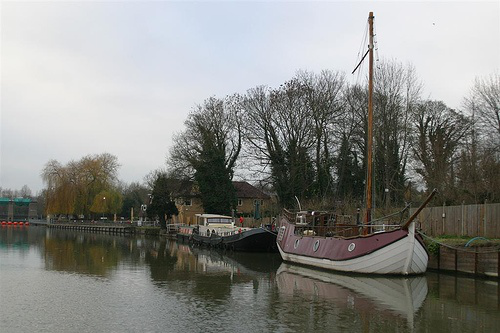

In [ ]:
from PIL import Image
Image.open(data_path / '2007_000061.jpg')

We want to count the number of occurences of each class in the 500+ files we have at our disposal.

```
TODO
1. read all txt files and iterate over them - Path and glob function,
2. filter labels.txt file,
3. using pandas to read column 0 and append it to the classes list,
4. concat the list into a pandas dataframe,
5. return the count using value_counts function
```

In [ ]:
# Get annotations from txt files
def count_objects(data_path):
    """
    Function reading all yolo format txt files and returning number of objects by class

    <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    <object-class> - integer number of object from 0 to (classes-1)
    <XCenterRelative> <YCenterRelative> - center of the bounding box [0,1]
    <WidthRelative> <HeightRelative> - width and height [0,1]
    """
    files_path = data_path / "2*.txt"
    classes = anno_dict.values()
    data = []
    
    ### BEGIN SOLUTION

    # First save data in dict to avoid adding to df, for performance
    for fp in glob(str(files_path)):
        with open(fp, "r") as f:
            for l in f.readlines():
                file_contents = l.rstrip('\n').split(" ")
                data.append(file_contents)
            
    df = pd.DataFrame.from_records(data) 
    counts = df.groupby([0]).size().to_dict()

    # if class not in data, we initialise it with zero
    for i in range(len(anno_dict)):
        if not str(i) in counts:
            counts[str(i)] = 0 

    counts = pd.DataFrame(list(counts.items()), columns = ["class", "n"])
    return counts
    ### END SOLUTION

# ! ls $data_path
# ! cat $data_path/2007_000061.txt

counts = count_objects(data_path)
pprint(counts)


   class    n
0      0  416
1      1  149
2     10    8
3     11    2
4     12    3
5     13    1
6      2  165
7      3  572
8      4  170
9      5  139
10     6  113
11     7   66
12     8   37
13     9   55


In [ ]:
count_df = count_objects(data_path)
# If assert launch an error there is an error in your code, else it is OK.
print(count_df)
assert len(count_df) == 14


   class    n
0      0  416
1      1  149
2     10    8
3     11    2
4     12    3
5     13    1
6      2  165
7      3  572
8      4  170
9      5  139
10     6  113
11     7   66
12     8   37
13     9   55


To improve readability replace index by class names using the dictionnary anno_dict.

```
TODO
Replace index by class names with one command
```

Hint : Use pandas.rename function.

In [ ]:
### BEGIN SOLUTION
count_df = count_objects(data_path)

count_df = count_df.set_index('class')
count_df.index = pd.to_numeric(count_df.index, errors='coerce')
count_df = count_df.rename(anno_dict).T
print(count_df)

### END SOLUTION
assert count_df['sail']['n'] == 165


class  boat  buoy  OFNI  kite  windsurf  surfboard  sail  person  kayak  \
n       416   149     8     2         3          1   165     572    170   

class  motor_sail  ferry  vessel  zodiac  fishing_boat  
n             139    113      66      37            55  


To improve the effectiveness of the TP we use a small dataset, which is still long to train. Futhermore the dataset is unbalanced, which is a difficulty to train a robust detector. 

In industrial applications several thousands of annotations by class are needed to obtain an acceptable performance. We'll keep that in mind when analysing results.

## Exercise 2: Code a dataloader

To exploit the images and their annotations, we need to write a dataloader in order to iterate through the images in the Pytorch format.

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. **Then we need to modify class 0 - boat, in order to make a difference from the background. We will replace 0 by 14.**

```
TODO
Implement __getitem__ function by following comments in the code
```

In [ ]:
class VocDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(Path(root).glob('*.jpg')))
        self.bboxes = list(sorted(Path(root).glob('*.txt')))[:-1] # ignore labels.txt


    def __getitem__(self, idx):
        # BEGIN SOLUTION

        # get image and bounding boxes paths
        img_path = self.imgs[idx]
        bbox_path = self.bboxes[idx]
        # open image and convert to RGB
        img = Image.open(img_path).convert("RGB")

        # get width and height
        width, height = img.size
        # get bounding boxes
        bbox_df = pd.read_csv(bbox_path, sep=' ', header=None)

        # print(bbox_df)
            
        # get bounding box coordinates
        # YOLO format reminder :
        # <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
        boxes = []
        labels = []
        for index, row in bbox_df.iterrows():
            obj_class, x_center, y_center, w_rel, height_rel = row
            xmin = (x_center - w_rel / 2) * width
            xmax = (x_center + w_rel / 2) * width
            ymin = (y_center - height_rel / 2) * height
            ymax = (y_center + height_rel / 2) * height

            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
            
            # replace label 0 by 14
            if obj_class == 0:
                obj_class = 14 
            labels.append(obj_class)
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # convert labels to a torch.Tensor
        labels =  torch.tensor(labels, dtype=torch.int64)

        # get image id
        image_id = torch.tensor([idx])
        # compute area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(bbox_df),), dtype=torch.int64)

        # populate target dictionnary
        target = {}
        target["boxes"] =  boxes
        target["labels"] =  labels
        target["image_id"] =  image_id
        target["area"] =  area
        target["iscrowd"] =  iscrowd
        
        ### END SOLUTION

        # image transformation
        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target


    def __len__(self):
        return len(self.imgs)

dataset = VocDataset(data_path)
print(dataset[1][1])


{'boxes': tensor([[358.1602, 182.9998, 499.9998, 275.2869],
        [ 64.9847, 109.0001, 131.5703, 209.0329],
        [246.8533, 140.1279, 340.2718, 213.6703]]), 'labels': tensor([14,  5, 14]), 'image_id': tensor([1]), 'area': tensor([13089.9580,  6660.7305,  6870.2183]), 'iscrowd': tensor([0, 0, 0])}


<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


Let now get the result tuple for the first image and plot it with ground truth annotations to see if the data seems correctly read.

In [ ]:
dataset = VocDataset(data_path)
assert torch.equal(dataset[2][1]['area'], torch.tensor([22363.4668]))
assert torch.equal(dataset[1][1]['labels'], torch.tensor([14, 5, 14]))
dataset[0]

<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


(<PIL.Image.Image image mode=RGB size=500x333 at 0x7FB79ACA3C10>,
 {'boxes': tensor([[274.0000,  10.9998, 437.0000, 278.9999],
          [187.3420, 214.0001, 281.0000, 252.0001]]),
  'labels': tensor([5, 6]),
  'image_id': tensor([0]),
  'area': tensor([43684.0117,  3559.0000]),
  'iscrowd': tensor([0, 0])})

In [ ]:
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


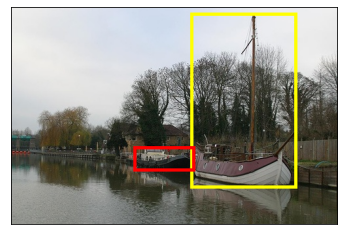

In [ ]:
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

path_img = Path(data_path) / '2007_000061.jpg'
img1_int = read_image(str(path_img))
colors = ["yellow", "red"]
result = draw_bounding_boxes(img1_int, dataset[0][1]['boxes'], colors=colors, width=5)
show(result)

<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


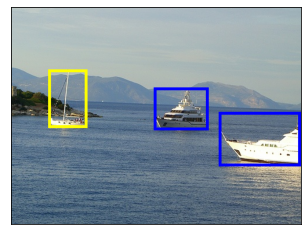

In [ ]:
path_img2 = data_path / '2007_000241.jpg'
img2_int = read_image(str(path_img2))
colors = ["blue", "yellow", "blue"]
result = draw_bounding_boxes(img2_int, dataset[1][1]['boxes'], colors=colors, width=5)
show(result)

The dataloader seems to do the job. If you are curious about the dataset you can plot other images, or create a grib with several ones.

## Exercise 3: Define a model

In this tutorial, we will be using faster R-CNN as described in class. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://www.researchgate.net/profile/Zhipeng-Deng-2/publication/324903264/figure/fig2/AS:640145124499471@1529633899620/The-architecture-of-Faster-R-CNN.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

We are in the first case to use all the power of a pretrained model. We'll load Faster R-CNN with pretrained weights before retraining it on the images we have. By that means we accelerate the training of the model.

```
TODO
1. load a pretrained fasterrcnn_resnet50_fpn
2. get number of input features for the classifier
3. replace the pre-trained head with a new one
```

In [ ]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
def get_detection_model(num_classes):
    ### BEGIN SOLUTION

    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    ### END SOLUTION

    return model


## Exercise 4: Preparing training loop

In references/detection/, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use references/detection/engine.py, references/detection/utils.py and references/detection/transforms.py.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 288493, done.
remote: Counting objects: 100% (9619/9619), done.
remote: Compressing objects: 100% (653/653), done.
remote: Total 288493 (delta 9047), reused 9437 (delta 8944), pack-reused 278874
Receiving objects: 100% (288493/288493), 582.76 MiB | 41.13 MiB/s, done.
Resolving deltas: 100% (264172/264172), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


### Data augmentation

To go deeper into the training process we want to do data augmentation by applying random transformations to the images. It allows the model to train longer without overfitting and augment programmatically the dataset size and the genericity of the model.

You can find the reference of the transformations here: https://pytorch.org/vision/stable/transforms.html

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

### Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

```
TODO
Follow the comments on the next cell
```

In [ ]:
import utils

### BEGIN SOLUTION

# get model and dataset with augmentations
num_classes = len(anno_dict) + 1
model = get_detection_model(num_classes)
dataset = VocDataset(data_path)

# create dataloader with torch.utils.data.DataLoader
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# For training
# get next batch images + targets by iterating on the data_loader

images, targets = next(iter(data_loader))
print(targets)

# Convert images and targets into the desired format by the model
# Hint : use list comprehension

images_formatted = []
for im in images:
    img = torch.from_numpy(np.array(im))
    # Changing the format of each image, also doable in a transform
    img = torch.permute(img, [2, 1, 0]) / 255 
    images_formatted.append(img)

images = images_formatted # look expected images values https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
targets = targets  # look expected targets values https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
output = model(images, targets)  # Returns losses and detections

### END SOLUTION

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)
<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


({'boxes': tensor([[474.0000, 300.0000, 484.0000, 313.0600],
        [  2.0000,   1.9999, 439.0000, 341.9999],
        [194.0000, 302.6574, 248.0000, 320.2121],
        [261.2155, 303.9575, 290.4735, 314.0352]]), 'labels': tensor([14,  5,  8,  8]), 'image_id': tensor([513]), 'area': tensor([1.3060e+02, 1.4858e+05, 9.4795e+02, 2.9485e+02]), 'iscrowd': tensor([0, 0, 0, 0])}, {'boxes': tensor([[355.5100,  94.9999, 461.1860, 276.2809],
        [412.0000, 243.9999, 441.0000, 263.9998],
        [ 29.0000,  55.0001, 146.0000, 279.9251],
        [ 87.0000, 237.0000, 118.0000, 264.0000],
        [ 90.0000, 104.9998, 174.9670, 264.9999],
        [130.0000, 228.0002, 152.0000, 251.0001]]), 'labels': tensor([2, 3, 2, 3, 2, 3]), 'image_id': tensor([363]), 'area': tensor([19157.0508,   579.9965, 26316.2227,   837.0000, 13594.7295,   505.9973]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])})


In [ ]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) # Returns predictions
predictions

[{'boxes': tensor([[  0.0000,  36.3924, 141.0633, 161.7998],
          [327.6203,  64.2599, 332.2323,  69.1408],
          [  0.0000, 145.3565, 201.6961, 234.5640],
          [328.8727,  65.0959, 334.9497,  68.4677],
          [  0.0000,  51.6099, 264.2627, 136.0691],
          [  0.0000,  85.7412, 202.9274, 166.4797],
          [  0.0000,  14.8738, 201.8725,  72.1942],
          [  0.0000, 115.9644, 234.9355, 208.4984],
          [191.1125, 168.9946, 195.6668, 173.6345],
          [326.8702,  63.1745, 331.3408,  68.3034],
          [ 14.8775, 216.3949, 221.3699, 272.3344],
          [  0.0000, 210.0263, 400.0000, 293.7643],
          [307.1304,  59.0097, 311.1311,  63.1955],
          [  0.0000, 239.5044, 204.5385, 281.6071],
          [190.4618, 167.2477, 195.1487, 171.5935],
          [180.4990, 227.3683, 185.5317, 232.3410],
          [  0.0000, 169.0551, 293.7924, 284.9018],
          [304.2425, 204.0714, 308.3334, 208.9880],
          [309.7873,  59.4969, 313.8283,  64.2008],
   

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

## Exercise 5: Putting everything together

We now have the dataset class, the model, the data transform and a hint about the dataloader. Let's instantiate them to launch a full training process.

First we want to create train/test split for the training and apply dataloaders to each one.

In [ ]:
from engine import train_one_epoch, evaluate

### BEGIN SOLUTION

# use our dataset and defined transformations
dataset_train = VocDataset(root=data_path, transform=get_transform(train=True))
dataset_test = VocDataset(root=data_path, transform=get_transform(train=False))


# split the dataset in train and test set with torch.utils.data.Subset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
train_size = int(0.9 * len(indices))
dataset = torch.utils.data.Subset(dataset_train, indices=indices[:train_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices=indices[train_size:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
) # use a batch_size of 4, 2 workers and the shuffle option

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
) # use a batch_size of 2, 2 workers and disable the shuffle option

### END SOLUTION

Then, instantiate the model and the optimizer.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 14 classes but bg class is set to 0
num_classes = 15

### BEGIN SOLUTION

# get the model using our helper function
model = get_detection_model(num_classes)
# move model to the right device
model = model.to(device)


# construct an optimizer SGD with lr=0.005, momentum=0.9 and weight_decay=0.0005
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)


# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### END SOLUTION

In [ ]:
evaluate(model, data_loader, device)


<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


creating index...
index created!
Test:  [  0/124]  eta: 0:17:49  model_time: 8.3840 (8.3840)  evaluator_time: 0.0118 (0.0118)  time: 8.6279  data: 0.2190  max mem: 1854
Test:  [100/124]  eta: 0:00:14  model_time: 0.5124 (0.5944)  evaluator_time: 0.0084 (0.0100)  time: 0.5477  data: 0.0136  max mem: 2731
Test:  [123/124]  eta: 0:00:00  model_time: 0.4532 (0.5751)  evaluator_time: 0.0081 (0.0098)  time: 0.5058  data: 0.0133  max mem: 2731
Test: Total time: 0:01:14 (0.6033 s / it)
Averaged stats: model_time: 0.4532 (0.5751)  evaluator_time: 0.0081 (0.0098)
Accumulating evaluation results...
DONE (t=0.51s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

And now let's train the model for 3 epochs, evaluating at the end of every epoch.

It's time for you to take a 20 min break during the training.

In [ ]:
# let's train it for 3 epochs
num_epochs = 3

### BEGIN SOLUTION

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations (use train_one_epoch function)
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset (use evaluate function)
    evaluate(model, data_loader, device)


### END SOLUTION

<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)
<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


Epoch: [0]  [  0/124]  eta: 0:04:32  lr: 0.000046  loss: 3.1664 (3.1664)  loss_classifier: 2.8538 (2.8538)  loss_box_reg: 0.2890 (0.2890)  loss_objectness: 0.0121 (0.0121)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 2.1982  data: 0.4279  max mem: 4432
Epoch: [0]  [ 10/124]  eta: 0:02:20  lr: 0.000452  loss: 2.7788 (2.5421)  loss_classifier: 2.3573 (2.1482)  loss_box_reg: 0.3599 (0.3455)  loss_objectness: 0.0204 (0.0217)  loss_rpn_box_reg: 0.0207 (0.0266)  time: 1.2359  data: 0.0509  max mem: 7045
Epoch: [0]  [ 20/124]  eta: 0:02:05  lr: 0.000858  loss: 1.3717 (1.8223)  loss_classifier: 0.9576 (1.4253)  loss_box_reg: 0.3481 (0.3390)  loss_objectness: 0.0204 (0.0287)  loss_rpn_box_reg: 0.0207 (0.0294)  time: 1.1556  data: 0.0133  max mem: 7177
Epoch: [0]  [ 30/124]  eta: 0:01:51  lr: 0.001264  loss: 1.1313 (1.6230)  loss_classifier: 0.5865 (1.1881)  loss_box_reg: 0.3421 (0.3586)  loss_objectness: 0.0247 (0.0427)  loss_rpn_box_reg: 0.0252 (0.0336)  time: 1.1618  data: 0.0133  max mem: 7177


<ipython-input-9-608282a13e5a>:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels =  torch.tensor(labels, dtype=torch.int64)


creating index...
index created!
Test:  [  0/124]  eta: 0:01:31  model_time: 0.5102 (0.5102)  evaluator_time: 0.0100 (0.0100)  time: 0.7391  data: 0.2160  max mem: 7556
Test:  [100/124]  eta: 0:00:13  model_time: 0.4549 (0.5172)  evaluator_time: 0.0122 (0.0136)  time: 0.5350  data: 0.0135  max mem: 7556
Test:  [123/124]  eta: 0:00:00  model_time: 0.4878 (0.5163)  evaluator_time: 0.0111 (0.0146)  time: 0.5537  data: 0.0130  max mem: 7556
Test: Total time: 0:01:08 (0.5501 s / it)
Averaged stats: model_time: 0.4878 (0.5163)  evaluator_time: 0.0111 (0.0146)
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

At each epoch, an evaluation process is launched to monitor the training. For the last epoch what AP do you get ? 

```
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.341
```

The final result can be seen in the code box above. Both the AP and AR scores improve gradually throughout the training.

### Checkpoints

We may now save the model and the state of optimizers and learning rate schedulers in order to continue training from where we left of. This is known as checkpointing.

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            }, 'checkpoint.pt')

We can then re-create model, optimizer and lr_scheduler from scratch and simply load their state from the checkpoint file we have just saved.

In case you have not been able to train your model during the break or have lost your model for some reason we provide you a checkpoint from this link which you can download and upload it to Colab to continue with the lab: [https://drive.google.com/file/d/1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ/view?usp=sharing](https://drive.google.com/file/d/1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ/view?usp=sharing)

We may download it directly to Colab by doing: 

```
gdown --id 1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ
```

In [ ]:
model = get_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
epoch = checkpoint['epoch']

model.eval()
# - or -
model.train()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Exercise 6: Visualize the result on an image

Computer Vision has the great advantage to be visual. Le's check the prediction on a an image.

In [ ]:
from torchvision.transforms.functional import convert_image_dtype

# Batch images
batch_int = torch.stack([img1_int])
batch = convert_image_dtype(batch_int, dtype=torch.float).to(device)

model = model.eval()

# Print images with model prediction
outputs = model(batch)
print(outputs)

[{'boxes': tensor([[182.5841, 211.8880, 277.2348, 247.7087],
        [276.7881,  23.7759, 431.2576, 298.5059],
        [269.2198, 192.4353, 433.5900, 270.0723],
        [262.8159,  98.7009, 447.8613, 263.5570],
        [282.5563,  27.0292, 449.1780, 276.8271],
        [272.4293, 189.3459, 430.7118, 273.6454],
        [272.2077,  42.1163, 434.4096, 275.2153],
        [254.1508,  10.2539, 447.8609, 287.8736],
        [191.3906, 209.5882, 277.4088, 252.7447],
        [225.7793, 227.4250, 277.2887, 250.8746],
        [189.8166, 213.6145, 244.3338, 239.2592],
        [272.5382, 196.1011, 431.7693, 271.7440],
        [198.1388, 223.5809, 281.5937, 252.5301]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([14,  5, 14, 14,  2,  6,  9,  6,  6, 14, 14,  4,  4], device='cuda:0'), 'scores': tensor([0.8325, 0.5370, 0.3861, 0.2934, 0.1420, 0.1124, 0.1099, 0.1078, 0.0964,
        0.0929, 0.0709, 0.0586, 0.0559], device='cuda:0',
       grad_fn=<IndexBackward0>)}]


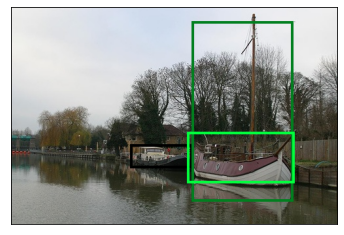

In [ ]:
# Select minimum threshold for keeping bbox
score_threshold = .3
# Show boxes
imgs_with_boxes = [
    draw_bounding_boxes(img_int,
                        boxes=output['boxes'][output['scores'] > score_threshold],
                        width=4)
    for img_int, output in zip(batch_int, outputs)
]
show(imgs_with_boxes)

Play with the score threshold. 

Can you select a good trade-off threshold ? 

Can you think of a technique to remove the duplicated bounding boxes ?

During testing a score threshold of `threshold = 0.5` has proved to be effective for showing the wanted objects and limiting false positives. 

In the following example, Non-Maximum-Supression (NMS) was used to eliminate overlapping bounding boxes. This enables setting a lower score threshold than in the upper example, since bounding boxes, which are positioned around 

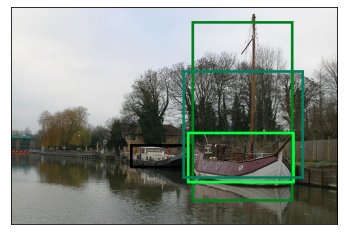

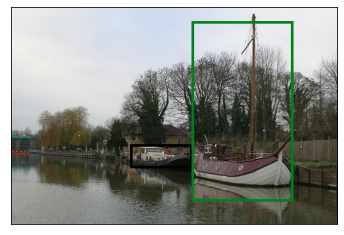

In [ ]:
# Apply the filtering solution
from torchvision import ops

### BEGIN SOLUTION

# Show the min threshold method for comparison
score_threshold = 0.2

imgs_with_boxes = [
    draw_bounding_boxes(img_int,
                        boxes=output['boxes'][output['scores'] > score_threshold],
                        width=4)
    for img_int, output in zip(batch_int, outputs)
]

# Using Non Maximum Supression for finding the best bounding boxes
imgs_with_boxes_improved = []
for img_int, output in zip(batch_int, outputs):
    nms_indices = torchvision.ops.nms(output['boxes'], output['scores'], iou_threshold=score_threshold),
    box = draw_bounding_boxes(img_int,
                        boxes=output['boxes'][nms_indices], 
                        width=4)
    imgs_with_boxes_improved.append(box)

show(imgs_with_boxes)
show(imgs_with_boxes_improved)


### END SOLUTION

## Exercise 7: Create a MVP (Minimum Viable Product)

To cope with the small unbalanced dataset we have, two solutions are available

* Get more data on the internet or at sea, but we don't have time to search and annotate new data. Annotation is a faily time-consuming process. [Make a try](https://www.makesense.ai/)
* Merge classes to simplify the problem and balance the data.

For example in our case 14 categories is detailed. Indeed we want to be able to separate

* small_vessel -> [boat, motor_sail, zodiac]
* big_vessel -> [ferry, vessel, fishing_boat]
* sail_vessel -> [sail, windsurf, kite]
* human_powered_vessel -> [kayak, surfboard]
* person
* other -> [buoy, OFNI]

```
TODO 
1. Modify the dictionnary of annotations.
2. Modify the dataLoader class to implement that merging process.
```

In [ ]:
!gdown 1ik0v3VJosH9E_UX62nGxl-hi75t36knJ
!tar -xf maritime_object_detection.tar

Downloading...
From: https://drive.google.com/uc?id=1ik0v3VJosH9E_UX62nGxl-hi75t36knJ
To: /content/maritime_object_detection.tar
100% 59.6M/59.6M [00:01<00:00, 55.3MB/s]


In [ ]:
# import torch packages
import pandas as pd 
import torch
import torch.nn as nn
import os
import time
from pathlib import Path
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T


# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files, drive
from glob import glob
from pprint import pprint

torch.manual_seed(1)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import utils
from engine import train_one_epoch, evaluate

In [ ]:
# New maritime dictionnary for MVP
new_maritime_dict = {
    0: "small_vessel",
    1: "big_vessel",
    2: "sail_vessel",
    3: "human_powered_vessel",
    4: "person",
    5: "other"
}

In [ ]:
# Create a dictionnary to convert labels
merging_dict = {
    0: 0,
    1: 5,
    2: 2,
    3: 4,
    4: 3,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 5,
    11: 2,
    12: 2,
    13: 3
}

data_path = Path('pascal_voc/train/')


Recreate count of all images to recreate class balance. You can use the function from exercise 1.

In [ ]:
# Get annotations from txt files
def mvp_count_objects(data_path):
    """
    Function reading all txt files from a yolo format and returning number of objects by class

    <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    <object-class> - integer number of object from 0 to (classes-1)
    <XCenterRelative> <YCenterRelative> - center of the bounding box [0,1]
    <WidthRelative> <HeightRelative> - width and height [0,1]
    """
    classes = []

    ### BEGIN SOLUTION
    files_path = data_path / "2*.txt"
    classes = new_maritime_dict.values()
    data = []
    
    ### BEGIN SOLUTION

    # First save data in dict to avoid adding to df, for performance
    for fp in glob(str(files_path)):
        with open(fp, "r") as f:
            for l in f.readlines():
                file_contents = l.rstrip('\n').split(" ")
                
                # merging into new categories
                #print(file_contents)
                
                file_contents[0] = merging_dict.get(int(file_contents[0]))
                #print(file_contents[0])
                data.append(file_contents)
            
    df = pd.DataFrame.from_records(data) 
    counts = df.groupby([0]).size().to_dict()

    counts = pd.DataFrame(list(counts.items()), columns = ["class", "n"])
    return counts

import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
def get_detection_model(num_classes=7):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_detection_model()

In [ ]:
# apply count and rename classes
### BEGIN SOLUTION
count_df = mvp_count_objects(data_path)
count_df = count_df.set_index('class')
count_df.index = pd.to_numeric(count_df.index, errors='coerce')
count_df = count_df.rename(new_maritime_dict).T
print(count_df)

### END SOLUTION
assert count_df['sail_vessel']['n']  == 170
count_df

class  small_vessel  big_vessel  sail_vessel  human_powered_vessel  person  \
n               592         234          170                   171     572   

class  other  
n        157  


class,small_vessel,big_vessel,sail_vessel,human_powered_vessel,person,other
n,592,234,170,171,572,157


Now that we can see that the dataset is more balanced, let's modify the dataloader to modify the class during the loading of the data.

In [ ]:
class VocDataset(torch.utils.data.Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    # load all image files, sorting them to ensure that they are aligned
    self.imgs = list(sorted(Path(root).glob('*.jpg')))
    self.bboxes = list(sorted(Path(root).glob('*.txt')))[:-1] # ignore labels.txt


  def __getitem__(self, idx):

    # get image and bounding boxes paths
    img_path = os.path.join(self.imgs[idx])
    bbox_path = os.path.join(self.bboxes[idx])
    # open image and convert to RGB
    img = Image.open(img_path).convert("RGB")
    # get width and height
    width, height = img.size
    # get bounding boxes
    bbox_df = pd.read_csv(bbox_path, sep=' ', header=None)
        
    # get bounding box coordinates
    # YOLO format reminder :
    # <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    boxes = []
    labels = []
    for index, row in bbox_df.iterrows():
        obj_class, x_center, y_center, w_rel, height_rel = row
        xmin = (x_center - w_rel / 2) * width
        xmax = (x_center + w_rel / 2) * width
        ymin = (y_center - height_rel / 2) * height
        ymax = (y_center + height_rel / 2) * height

        if xmin < xmax and ymin < ymax:
            boxes.append([xmin, ymin, xmax, ymax])
        
        new_class = merging_dict.get(obj_class)
        # replace label 0 by 6
        if int(new_class) == 0:
            new_class = 6
        labels.append(new_class)

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    ## BEGIN SOLUTION
    # replace labels with new dict
    labels = torch.tensor(labels, dtype=torch.int64)

    ### END SOLUTION

    # get image od
    image_id = torch.tensor([idx])
    # compute area of the bounding boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((len(bbox_df),), dtype=torch.int64)

    # populate target dictionnary
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    # image transformation
    if self.transform is not None:
        img, target = self.transform(img, target)

    return img, target


  def __len__(self):
    return len(self.imgs)

In [ ]:
dataset = VocDataset(data_path)
print(dataset[0][1]['labels'])
assert torch.equal(dataset[0][1]['labels'], torch.tensor([6,1]))
dataset[0]

tensor([6, 1])


(<PIL.Image.Image image mode=RGB size=500x333 at 0x7FB78024BBE0>,
 {'boxes': tensor([[274.0000,  10.9998, 437.0000, 278.9999],
          [187.3420, 214.0001, 281.0000, 252.0001]]),
  'labels': tensor([6, 1]),
  'image_id': tensor([0]),
  'area': tensor([43684.0117,  3559.0000]),
  'iscrowd': tensor([0, 0])})

Labels [5, 6] have been transformed to [6, 1]

## Exercise 8: Retrain the model

Train the model with the new dataset. 

Take code already written in exercise 5 and modify it to train the model again.

In [ ]:
### BEGIN SOLUTION

dataset_train = VocDataset(root=data_path, transform=get_transform(train=True))
dataset_test = VocDataset(root=data_path, transform=get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
train_size = int(0.9 * len(indices))
dataset = torch.utils.data.Subset(dataset_train, indices=indices[:train_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices=indices[train_size:])

data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Currently training on {device}")

num_classes = len(new_maritime_dict) + 1
model = get_detection_model(num_classes)
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    lr_scheduler.step()

    evaluate(model, data_loader, device)


Currently training on cuda
Epoch: [0]  [  0/138]  eta: 0:03:52  lr: 0.000041  loss: 2.4478 (2.4478)  loss_classifier: 1.9391 (1.9391)  loss_box_reg: 0.4744 (0.4744)  loss_objectness: 0.0180 (0.0180)  loss_rpn_box_reg: 0.0162 (0.0162)  time: 1.6843  data: 0.2845  max mem: 8290
Epoch: [0]  [ 10/138]  eta: 0:02:53  lr: 0.000406  loss: 2.0431 (1.9035)  loss_classifier: 1.6322 (1.4486)  loss_box_reg: 0.4127 (0.3706)  loss_objectness: 0.0180 (0.0497)  loss_rpn_box_reg: 0.0184 (0.0346)  time: 1.3567  data: 0.0382  max mem: 8290
Epoch: [0]  [ 20/138]  eta: 0:02:32  lr: 0.000771  loss: 1.2791 (1.4243)  loss_classifier: 0.6296 (0.9929)  loss_box_reg: 0.3285 (0.3568)  loss_objectness: 0.0204 (0.0468)  loss_rpn_box_reg: 0.0156 (0.0277)  time: 1.2687  data: 0.0139  max mem: 8610
Epoch: [0]  [ 30/138]  eta: 0:02:14  lr: 0.001135  loss: 0.7665 (1.2419)  loss_classifier: 0.4230 (0.8265)  loss_box_reg: 0.3068 (0.3500)  loss_objectness: 0.0223 (0.0393)  loss_rpn_box_reg: 0.0128 (0.0261)  time: 1.1859  d

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            }, 'checkpoint_new.pt')

Can you explain the new AP score of the model on this simpler dataset ?

Answer: 

The newer model has better precision, due to the merging of categories. Misdetections between objects of the same categories are not counted as a mistake, thus precision rises, compared to the model above.

## Exercise 9: Test on new images

Take images on Google or where you want to apply the model on it, in a maritime context or in completely different one.

Try to answer those questions with empirical test:

1. Is the model good on all situation ?
2. Can you see a difference on small/medium/large objects ?
3. Can you isolate difficult images for it ?
4. Easy ones ?
5. Do you have good accuracy on different weather ?
6. Considering your answers how could you improve the dataset to improve the training of the model ?

In [ ]:
from google.colab import drive
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

drive.mount('/content/drive')

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Mounted at /content/drive


Currently showing image: 0
Currently showing image: 1
Currently showing image: 2
Currently showing image: 3
Currently showing image: 4
Currently showing image: 5
Currently showing image: 6
Currently showing image: 7
Currently showing image: 8
Currently showing image: 9
Currently showing image: 10
Currently showing image: 11
Currently showing image: 12
Currently showing image: 13
Currently showing image: 14
Currently showing image: 15


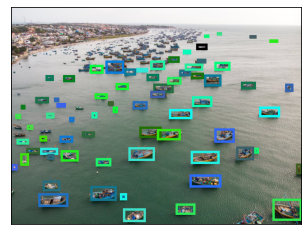

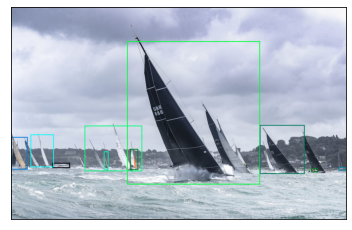

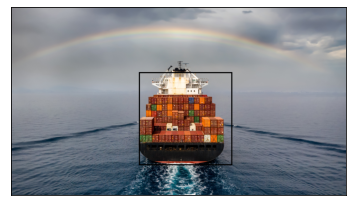

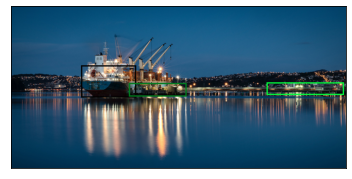

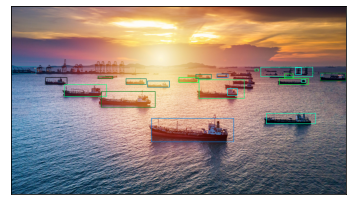

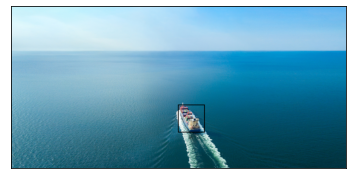

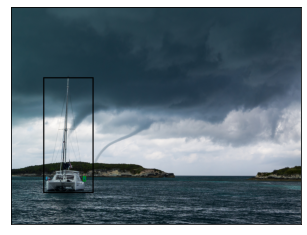

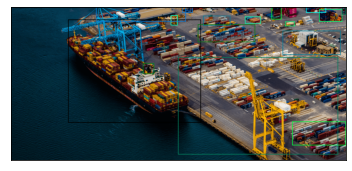

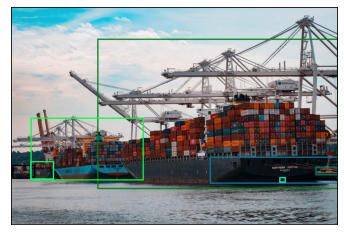

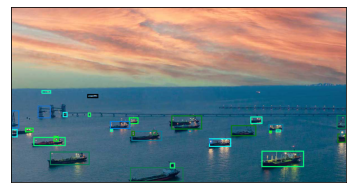

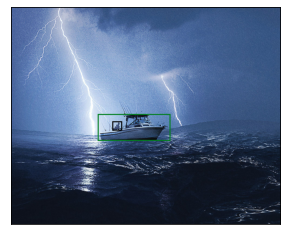

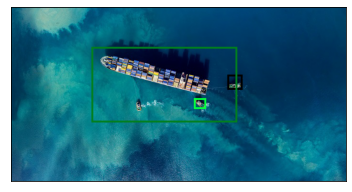

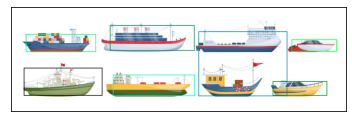

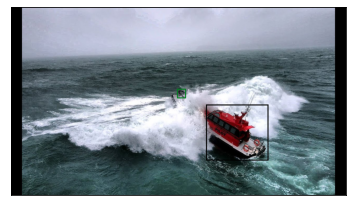

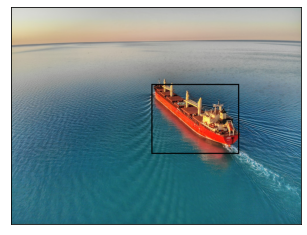

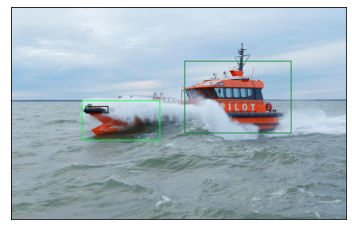

In [ ]:
new_images_path = Path("/content/drive/MyDrive/public/MIR/deep_learning/maritime_images")
path_imgs = new_images_path / "*.jpg"

model = model.eval()

import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor()
    ]
)

transform_to_rgb = transforms.Compose([
    transforms.PILToTensor()
])


dataset_new = torchvision.datasets.ImageFolder(str(new_images_path), transform=transform)
data_loader_new = torch.utils.data.DataLoader(
    dataset_new,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

score_threshold = 0.1

for i, batch in enumerate(data_loader_new):
    data, label = batch
    print(f"Currently showing image: {i}")

    data = data[0].to(device)

    # For creating a batch
    data = torch.unsqueeze(data, dim=0)
    outputs = model(data)

    imgs_with_boxes_improved = []
    for img_int, output in zip(data, outputs):
        # Ugly conversion between images for right type
        # originally values (0, 1), now (0, 255) RGB
        img = torchvision.transforms.ToPILImage()(img_int)
        img = transform_to_rgb(img)
        nms_indices = torchvision.ops.nms(output['boxes'], output['scores'], iou_threshold=score_threshold),
        box = draw_bounding_boxes(img,
                            boxes=output['boxes'][nms_indices], 
                            width=4)
        imgs_with_boxes_improved.append(box)

    show(imgs_with_boxes_improved)


Answer:

Is the model good in all situations ?
The upper model achieves high recall, showing almost always all objects present in the scene. Some parts of boats are detected multiple times, due to waves blocking direct sight. 

Can you see a difference on small/medium/large objects ?
The model performs worse on smaller objects. When large objects are shown individually on an image, they are mostly categorised correctly. 

Can you isolate difficult images for it ?
Darker lighting conditions seem to have a strong negative impact on detection quality. 

Easy ones ?
When the lightng of the scene is good, the model shows high precision and recall. 

Do you have good accuracy on different weather ?
While lighting seems to have a big impact on detection quality, the presence of e.g. rain does not seem to play a big factor. 

Considering your answers how could you improve the dataset to improve the training of the model ?
During training more images depicting boats in darker scenes should be included. Data augmentation may also be used to artificially darken the test images. 

## Optional Exercise 10: Train another model of your choice

To go deeper with object detection, you can try different models. A list of all available models is accessible in the [model zoo](https://pytorch.org/vision/stable/models.html).

Do a benchmark of the three models used so far.  
What is the best accuracy ? best speed ? ...

In [ ]:
# Optional